# Utils

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [10]:
from lab1_utils import train_loop, train_loop_sched, train, test, get_lr, count_trainable_parameters
from lab1_utils import save_to_json
from lab1_utils import multiple_diagnostic, test_class

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

max_epochs = 20
criterion = torch.nn.CrossEntropyLoss()  # input requires logits

Define a basic network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 11 * 11, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # logits
        return x

In [5]:
mod = Net()

print(summary(mod))
print(mod(torch.rand(1, 3, 32, 32)))

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            448
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            495,680
├─Linear: 1-6                            650
├─ReLU: 1-7                              --
Total params: 519,914
Trainable params: 519,914
Non-trainable params: 0
tensor([[ 0.1099, -0.0811,  0.0427, -0.1286, -0.0934,  0.0893, -0.0391, -0.0878,
         -0.0170,  0.1037]], grad_fn=<AddmmBackward0>)


# Exercise 0

In [5]:
# without normalization
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
mean = torch.zeros(3)  # a mean for each channel, here 1
std = torch.zeros(3)  # a std for each channel, here 1
samples = 0

# simple because we only have one channel, that is greyscale
for X, y in trainloader:
    # width and height over one dimension
    X = torch.flatten(X, 2, 3)
    # [batch_size, 3, 28*28]
    # compute mean and std over each channel then sum and store
    mean += X.mean(2).sum(0)
    std += X.std(2).sum(0)
    samples += X.size(0)

print(f"Samples {samples}")
mean /= samples
print(f"Mean {mean}")
std /= samples
print(f"Std {std}")

Samples 50000
Mean tensor([0.4914, 0.4822, 0.4465])
Std tensor([0.2023, 0.1994, 0.2010])


In [7]:
# normalize data correctly
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# Exercise 1
Learning rate scheduler

In [8]:
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

In [9]:
es1_loss_acc = {}  # {"Solver1": [loss, acc]}

## Basic training

In [11]:
model1 = Net()
model1.to(device)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

es1_loss_acc["SGD"] = [stats[0], stats[3]]

test_class(model1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.9669, Accuracy: 0.293, Runtime: 7.63
Test - Loss: 1.6501, Accuracy: 0.405
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5441, Accuracy: 0.445, Runtime: 7.49
Test - Loss: 1.5080, Accuracy: 0.470
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.3773, Accuracy: 0.509, Runtime: 7.37
Test - Loss: 1.3558, Accuracy: 0.524
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.2730, Accuracy: 0.552, Runtime: 7.32
Test - Loss: 1.2359, Accuracy: 0.565
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.1913, Accuracy: 0.585, Runtime: 7.51
Test - Loss: 1.1941, Accuracy: 0.576
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1128, Accuracy: 0.611, Runtime: 7.49
Test - Loss: 1.0956, Accuracy: 0.614
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0405, Accuracy: 0.635, Runtime: 7.28
Test - Loss: 1.0768, Accuracy: 0.625
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.9747, Accuracy: 0.661, Runtime: 7.34
Test - Loss: 1.0247, 

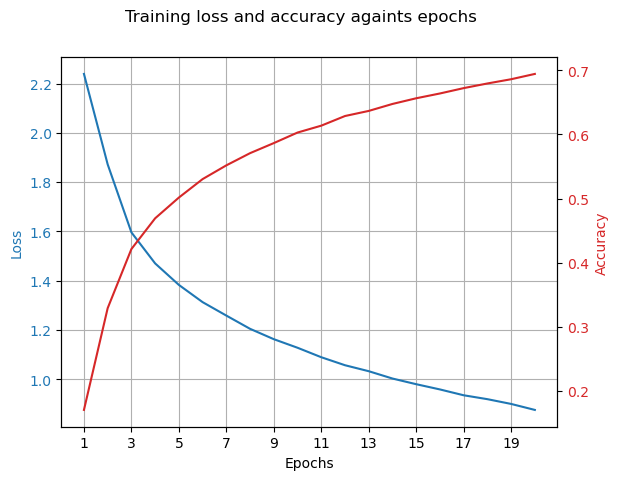

In [29]:
simple_diagnostic(max_epochs, stats[0], stats[1])
plt.savefig("./plots/es1-sgd.pdf")

## Multi-step scheduler

In [12]:
model2 = Net()
model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)

stats = train_loop_sched(trainloader, testloader, model2, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Step"] = [stats[0], stats[3]]

test_class(model2, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.5299, Accuracy: 0.446, Runtime: 7.27
Test - Loss: 1.2805, Accuracy: 0.548
Epoch: 2, Learning rate: 0.010000
Training - Loss: 1.1220, Accuracy: 0.604, Runtime: 7.31
Test - Loss: 1.0316, Accuracy: 0.634
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.9233, Accuracy: 0.675, Runtime: 7.35
Test - Loss: 0.9809, Accuracy: 0.659
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.7896, Accuracy: 0.722, Runtime: 7.34
Test - Loss: 0.9566, Accuracy: 0.671
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.6752, Accuracy: 0.761, Runtime: 7.37
Test - Loss: 0.9749, Accuracy: 0.679
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.3895, Accuracy: 0.866, Runtime: 7.34
Test - Loss: 0.9184, Accuracy: 0.717
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.3212, Accuracy: 0.892, Runtime: 7.32
Test - Loss: 0.9576, Accuracy: 0.716
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2787, Accuracy: 0.908, Runtime: 7.35
Test - Loss: 1.0073, 

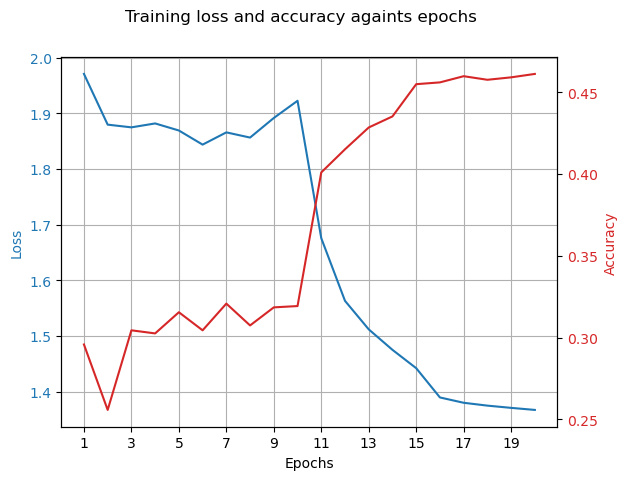

In [35]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-step.pdf")

## Exponential scheduler

In [13]:
model3 = Net()
model3.to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.9)  # a_k *= 0.95**k

stats = train_loop_sched(trainloader, testloader, model3, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Exp"] = [stats[0], stats[3]]

test_class(model3, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.5758, Accuracy: 0.429, Runtime: 8.03
Test - Loss: 1.2674, Accuracy: 0.549
Epoch: 2, Learning rate: 0.009000
Training - Loss: 1.1215, Accuracy: 0.603, Runtime: 8.98
Test - Loss: 1.0428, Accuracy: 0.631
Epoch: 3, Learning rate: 0.008100
Training - Loss: 0.9017, Accuracy: 0.684, Runtime: 8.14
Test - Loss: 0.9652, Accuracy: 0.659
Epoch: 4, Learning rate: 0.007290
Training - Loss: 0.7518, Accuracy: 0.739, Runtime: 7.91
Test - Loss: 0.9177, Accuracy: 0.682
Epoch: 5, Learning rate: 0.006561
Training - Loss: 0.6256, Accuracy: 0.781, Runtime: 7.86
Test - Loss: 0.9549, Accuracy: 0.691
Epoch: 6, Learning rate: 0.005905
Training - Loss: 0.5019, Accuracy: 0.824, Runtime: 7.29
Test - Loss: 0.9484, Accuracy: 0.701
Epoch: 7, Learning rate: 0.005314
Training - Loss: 0.3759, Accuracy: 0.868, Runtime: 7.27
Test - Loss: 1.0380, Accuracy: 0.707
Epoch: 8, Learning rate: 0.004783
Training - Loss: 0.2632, Accuracy: 0.908, Runtime: 7.32
Test - Loss: 1.1638, 

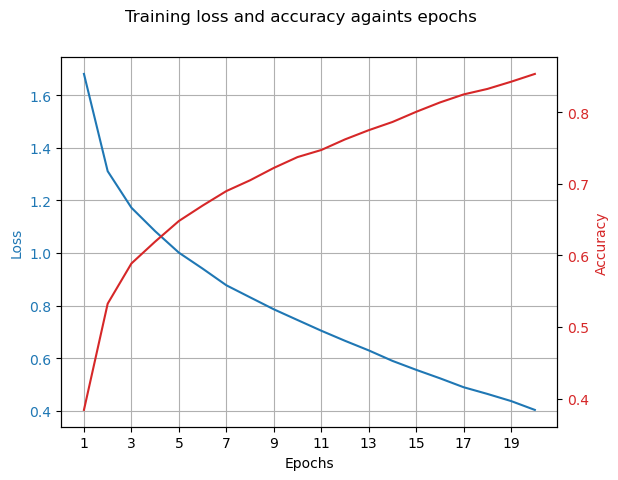

In [51]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-exp.pdf")

## Adam

In [14]:
model4 = Net()
model4.to(device)

optimizer = optim.Adam(model4.parameters(), lr=0.0001)

stats = train_loop_sched(trainloader, testloader, model4, criterion, device,
                         optimizer, max_epochs=max_epochs)

es1_loss_acc["Adam"] = [stats[0], stats[3]]

test_class(model4, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.000100
Training - Loss: 1.7180, Accuracy: 0.392, Runtime: 7.45
Test - Loss: 1.4940, Accuracy: 0.464
Epoch: 2, Learning rate: 0.000100
Training - Loss: 1.3975, Accuracy: 0.506, Runtime: 7.38
Test - Loss: 1.3652, Accuracy: 0.517
Epoch: 3, Learning rate: 0.000100
Training - Loss: 1.3039, Accuracy: 0.541, Runtime: 7.38
Test - Loss: 1.2773, Accuracy: 0.544
Epoch: 4, Learning rate: 0.000100
Training - Loss: 1.2410, Accuracy: 0.561, Runtime: 7.31
Test - Loss: 1.2274, Accuracy: 0.566
Epoch: 5, Learning rate: 0.000100
Training - Loss: 1.1889, Accuracy: 0.585, Runtime: 7.34
Test - Loss: 1.1798, Accuracy: 0.585
Epoch: 6, Learning rate: 0.000100
Training - Loss: 1.1419, Accuracy: 0.600, Runtime: 7.35
Test - Loss: 1.1409, Accuracy: 0.600
Epoch: 7, Learning rate: 0.000100
Training - Loss: 1.0960, Accuracy: 0.617, Runtime: 7.33
Test - Loss: 1.1189, Accuracy: 0.611
Epoch: 8, Learning rate: 0.000100
Training - Loss: 1.0530, Accuracy: 0.635, Runtime: 7.36
Test - Loss: 1.0789, 

## Cosine annealing

In [15]:
model5 = Net()
model5.to(device)

optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

stats = train_loop_sched(trainloader, testloader, model5, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Cos"] = [stats[0], stats[3]]

test_class(model5, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.5366, Accuracy: 0.443, Runtime: 7.27
Test - Loss: 1.2966, Accuracy: 0.539
Epoch: 2, Learning rate: 0.009973
Training - Loss: 1.1217, Accuracy: 0.603, Runtime: 7.32
Test - Loss: 1.0324, Accuracy: 0.636
Epoch: 3, Learning rate: 0.009891
Training - Loss: 0.9285, Accuracy: 0.673, Runtime: 7.36
Test - Loss: 0.9743, Accuracy: 0.662
Epoch: 4, Learning rate: 0.009755
Training - Loss: 0.7843, Accuracy: 0.725, Runtime: 7.31
Test - Loss: 0.9411, Accuracy: 0.679
Epoch: 5, Learning rate: 0.009568
Training - Loss: 0.6627, Accuracy: 0.767, Runtime: 7.36
Test - Loss: 0.9532, Accuracy: 0.679
Epoch: 6, Learning rate: 0.009330
Training - Loss: 0.5348, Accuracy: 0.811, Runtime: 7.30
Test - Loss: 1.0277, Accuracy: 0.671
Epoch: 7, Learning rate: 0.009045
Training - Loss: 0.4326, Accuracy: 0.847, Runtime: 7.39
Test - Loss: 1.0761, Accuracy: 0.691
Epoch: 8, Learning rate: 0.008716
Training - Loss: 0.3284, Accuracy: 0.884, Runtime: 7.34
Test - Loss: 1.2428, 

## Reduce on plateau
Reduce learning rate when a metric has stopped improving

In [ ]:
model6 = Net()
model6.to(device)

optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, threshold=0.01)

stats = train_loop_sched(trainloader, testloader, model6, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Plateau"] = [stats[0], stats[3]]

test_class(model6, device, criterion, testloader, classes)

## Show optimizers performance

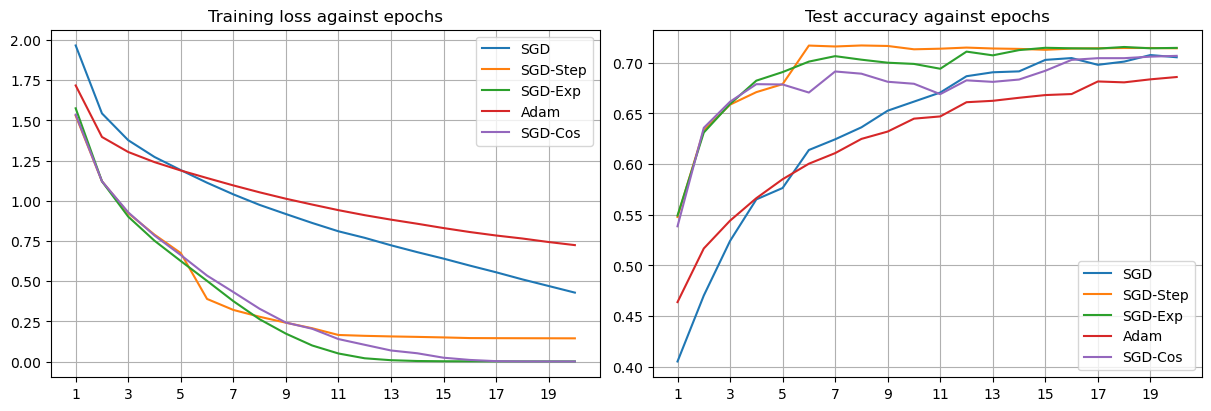

In [32]:
multiple_diagnostic(es1_loss_acc, max_epochs)
plt.savefig("./plots/cifar10-opt-diagnostic.pdf")

In [17]:
save_to_json(es1_loss_acc, "./plots/cifar10-opt-diagnostic.json")

# Excercise 2

In [10]:
transform = transforms.Compose([
    # geometric transforms
    # transforms.RandomRotation(degrees=20),  # rotates the image randomly within a range of -20 to 20 degrees
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(p=0.5),  # flips the image horizontally with a 50% probability
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # randomly crops between 80% and 100% of the original image and resizes to 32x32
    # color transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly changes the brightness, contrast, saturation, and hue of the image
    transforms.RandomGrayscale(p=0.1),  # converts the image to grayscale with a 10% probability
    # noise injection
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),  # applies a Gaussian blur with a specified range for sigma
    # normalization
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # randomly selects a rectangle region in an image and erases its pixels
    transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

In [19]:
es2_loss_acc = {}

In [20]:
es2_loss_acc["SGD"] = es1_loss_acc["SGD"]

In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


### Random affine transforms

In [22]:
transf1 = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf1)
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)

In [23]:
# model_transf_dict = dict(model=model_transf, criterion=criterion, device=device, lr=0.001, momentum=0.9,
#                          max_epochs=max_epochs, do_test=True)
# stats = train_loop(trainloader_1, testloader, **model_transf_dict)

model1 = Net()
model1.to(device)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader_1, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

es2_loss_acc["RandAff"] = [stats[0], stats[3]]

test_class(model1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.0645, Accuracy: 0.243, Runtime: 12.23
Test - Loss: 1.7842, Accuracy: 0.372
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.7066, Accuracy: 0.377, Runtime: 12.06
Test - Loss: 1.5326, Accuracy: 0.449
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.5868, Accuracy: 0.426, Runtime: 12.23
Test - Loss: 1.4479, Accuracy: 0.478
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.5007, Accuracy: 0.458, Runtime: 12.38
Test - Loss: 1.3523, Accuracy: 0.516
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.4341, Accuracy: 0.484, Runtime: 12.42
Test - Loss: 1.2813, Accuracy: 0.543
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.3741, Accuracy: 0.507, Runtime: 12.35
Test - Loss: 1.2314, Accuracy: 0.565
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.3309, Accuracy: 0.525, Runtime: 12.38
Test - Loss: 1.2358, Accuracy: 0.564
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.2899, Accuracy: 0.540, Runtime: 12.38
Test - Loss: 

### Random horizontal flip transforms

In [24]:
transf2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_2 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)

In [25]:
model1 = Net()
model1.to(device)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader_2, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

es2_loss_acc["HorizFlip"] = [stats[0], stats[3]]

test_class(model1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.0103, Accuracy: 0.276, Runtime: 9.73
Test - Loss: 1.7057, Accuracy: 0.387
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5588, Accuracy: 0.442, Runtime: 10.13
Test - Loss: 1.4955, Accuracy: 0.459
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.3863, Accuracy: 0.506, Runtime: 9.81
Test - Loss: 1.3167, Accuracy: 0.525
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.2811, Accuracy: 0.547, Runtime: 10.08
Test - Loss: 1.2414, Accuracy: 0.559
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.1969, Accuracy: 0.579, Runtime: 10.22
Test - Loss: 1.1749, Accuracy: 0.585
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1190, Accuracy: 0.607, Runtime: 10.08
Test - Loss: 1.1144, Accuracy: 0.605
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0549, Accuracy: 0.630, Runtime: 9.83
Test - Loss: 1.0309, Accuracy: 0.638
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.0010, Accuracy: 0.650, Runtime: 10.06
Test - Loss: 1.0

### Gaussian blur transforms

In [26]:
transf3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf3)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

In [27]:
model1 = Net()
model1.to(device)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader_3, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

es2_loss_acc["Blur"] = [stats[0], stats[3]]

test_class(model1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.0039, Accuracy: 0.276, Runtime: 26.35
Test - Loss: 1.7184, Accuracy: 0.366
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5678, Accuracy: 0.436, Runtime: 26.34
Test - Loss: 1.4203, Accuracy: 0.483
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.3973, Accuracy: 0.500, Runtime: 27.22
Test - Loss: 1.3593, Accuracy: 0.513
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.3049, Accuracy: 0.536, Runtime: 26.10
Test - Loss: 1.2600, Accuracy: 0.555
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.2297, Accuracy: 0.565, Runtime: 26.83
Test - Loss: 1.2184, Accuracy: 0.569
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1625, Accuracy: 0.590, Runtime: 26.29
Test - Loss: 1.1492, Accuracy: 0.596
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0966, Accuracy: 0.613, Runtime: 26.36
Test - Loss: 1.1077, Accuracy: 0.611
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.0384, Accuracy: 0.635, Runtime: 26.72
Test - Loss: 

### Color jitter

In [28]:
transf4 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_4 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf4)
trainloader_4 = torch.utils.data.DataLoader(trainset_4, batch_size=batch_size, shuffle=True, num_workers=2)

In [29]:
model1 = Net()
model1.to(device)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader_4, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

es2_loss_acc["Jitter"] = [stats[0], stats[3]]

test_class(model1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.9496, Accuracy: 0.298, Runtime: 22.85
Test - Loss: 1.6752, Accuracy: 0.401
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5529, Accuracy: 0.447, Runtime: 22.68
Test - Loss: 1.4110, Accuracy: 0.497
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.3961, Accuracy: 0.511, Runtime: 22.82
Test - Loss: 1.3029, Accuracy: 0.537
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.2828, Accuracy: 0.549, Runtime: 22.88
Test - Loss: 1.2158, Accuracy: 0.572
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.1930, Accuracy: 0.584, Runtime: 22.74
Test - Loss: 1.1329, Accuracy: 0.602
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1051, Accuracy: 0.614, Runtime: 22.69
Test - Loss: 1.0754, Accuracy: 0.622
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0356, Accuracy: 0.640, Runtime: 22.43
Test - Loss: 1.0086, Accuracy: 0.648
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.9719, Accuracy: 0.662, Runtime: 22.80
Test - Loss: 

### Show tranforms performance

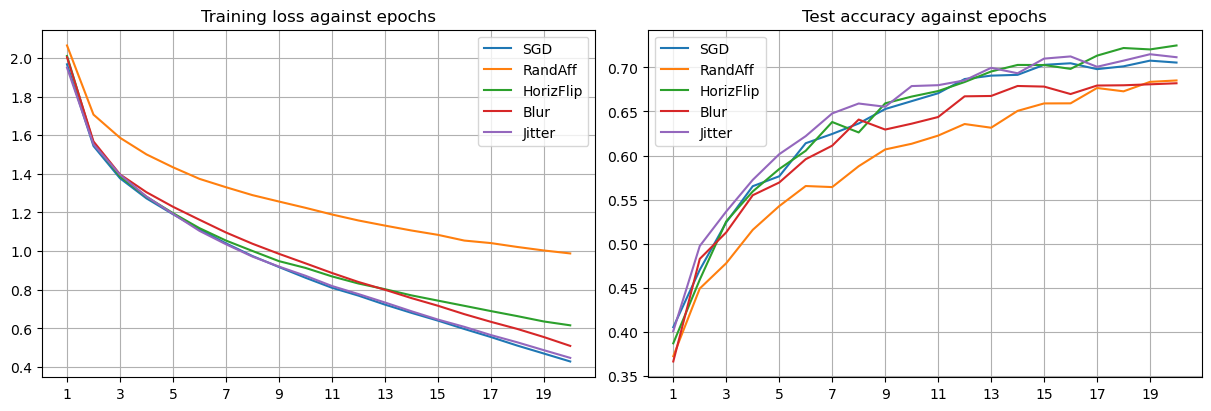

In [30]:
multiple_diagnostic(es2_loss_acc, max_epochs)
plt.savefig("./plots/cifar10-transforms-diagnostic.pdf")

In [31]:
save_to_json(es2_loss_acc, "./plots/cifar10-transforms-diagnostic.json")

### Show transforms

In [33]:
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

In [35]:
# plot real and augmented images
from torchvision.utils import make_grid

transf1 = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()])
trainset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf1)

transf2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])
trainset_2 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf2)

transf3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),
    transforms.ToTensor()])
trainset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf3)

transf4 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()])
trainset_4 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf4)

to_show = 20  # take the first images
imgs = torch.stack((*[non_augmented[i][0] for i in range(to_show)],
                    *[trainset_1[i][0] for i in range(to_show)],
                    *[trainset_2[i][0] for i in range(to_show)],
                    *[trainset_3[i][0] for i in range(to_show)],
                    *[trainset_4[i][0] for i in range(to_show)]))
grid = make_grid(imgs, nrow=to_show)

image = transforms.ToPILImage()(grid)
image.show()
image.save("./plots/transforms.png")

# Exercise 3

Fine-tuning of popular CNNs, use pre-trained as backbone

In [ ]:
import torchvision.models as models

### My Net

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
notransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

In [10]:
# con troppe trasformazioni va lento perché le applica online
transform = transforms.Compose([
    # geometric transforms
    # transforms.RandomRotation(degrees=20),  # rotates the image randomly within a range of -20 to 20 degrees
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(p=0.5),  # flips the image horizontally with a 50% probability
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # randomly crops between 80% and 100% of the original image and resizes to 32x32
    # color transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly changes the brightness, contrast, saturation, and hue of the image
    # transforms.RandomGrayscale(p=0.1),  # converts the image to grayscale with a 10% probability
    # noise injection
    # transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),  # applies a Gaussian blur with a specified range for sigma
    # normalization
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # randomly selects a rectangle region in an image and erases its pixels
    transforms.ToTensor(),
    # transforms.Resize(224),  # for alexnet
    transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Resize(224),  # for alexnet
     transforms.Normalize(mean, std)])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(20):
    loss_k, acc_k = train(model, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, Loss: {loss_k:.4f}, Accuracy: {acc_k:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")
# torch.save(model.state_dict(), 'net_augmented1.pth')

# es1_loss_acc["SGD"] = [losses, accs]

test_class(model, device, criterion, testloader)

Epoch: 0, Loss: 2.2560, Accuracy: 0.15, Runtime: 13.69
Epoch: 1, Loss: 1.9195, Accuracy: 0.31, Runtime: 13.73
Epoch: 2, Loss: 1.6988, Accuracy: 0.39, Runtime: 13.91
Epoch: 3, Loss: 1.5789, Accuracy: 0.44, Runtime: 13.71
Epoch: 4, Loss: 1.5040, Accuracy: 0.46, Runtime: 13.76
Epoch: 5, Loss: 1.4401, Accuracy: 0.49, Runtime: 13.66
Epoch: 6, Loss: 1.3854, Accuracy: 0.51, Runtime: 13.72
Epoch: 7, Loss: 1.3348, Accuracy: 0.53, Runtime: 13.64
Epoch: 8, Loss: 1.2886, Accuracy: 0.55, Runtime: 13.61
Epoch: 9, Loss: 1.2479, Accuracy: 0.56, Runtime: 13.58
Epoch: 10, Loss: 1.2126, Accuracy: 0.58, Runtime: 13.71
Epoch: 11, Loss: 1.1827, Accuracy: 0.59, Runtime: 13.62
Epoch: 12, Loss: 1.1538, Accuracy: 0.60, Runtime: 13.63
Epoch: 13, Loss: 1.1251, Accuracy: 0.61, Runtime: 13.63
Epoch: 14, Loss: 1.1103, Accuracy: 0.61, Runtime: 13.63
Epoch: 15, Loss: 1.0878, Accuracy: 0.62, Runtime: 13.57
Epoch: 16, Loss: 1.0643, Accuracy: 0.63, Runtime: 13.61
Epoch: 17, Loss: 1.0469, Accuracy: 0.64, Runtime: 13.62
Ep

### Train AlexNet

In [9]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
alexnet = models.alexnet(weights="DEFAULT")
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)
alexnet.to(device)

# print(f"Trainable parameters: {count_trainable_parameters(alexnet)}")
print(summary(alexnet))

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       23,296
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       307,392
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       663,936
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       884,992
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      590,080
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      37,752,832
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                   

In [11]:
# freeze all layers
for param in alexnet.parameters():
    param.requires_grad = False

# let final layer be trainable, that goes into classification head
alexnet.classifier[6].weight.requires_grad = True
alexnet.classifier[6].bias.requires_grad = True
# count_trainable_parameters(alexnet)  # 4096 * 10 + 1 (bias)
print(summary(alexnet))

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (23,296)
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       (307,392)
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       (663,936)
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       (884,992)
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      (590,080)
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      (37,752,832)
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17       

In [30]:
alexnet(torch.randn(1, 3, 224, 224).to(device))

tensor([[ 0.1415, -1.8886,  1.2051,  0.5140,  0.9456,  0.8066,  0.8011, -0.4020,
         -0.7322, -1.3658]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [14]:
from torch.optim.lr_scheduler import ExponentialLR

In [15]:
# alexnet_dict = dict(model=alexnet, criterion=criterion, device=device, lr=0.001, momentum=0.9,
#                     max_epochs=6, do_test=True)
# stats = train_loop(trainloader, testloader, **alexnet_dict)

optimizer = optim.SGD(alexnet.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.8)

stats = train_loop_sched(trainloader, testloader, alexnet, criterion,
                         device, optimizer, scheduler, 10)

print("=========")
test_class(alexnet, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.100000
Training - Loss: 18.2388, Accuracy: 0.67, Runtime: 33.01
Test - Loss: 15.9258, Accuracy: 0.72
Epoch: 2, Learning rate: 0.080000
Training - Loss: 13.8824, Accuracy: 0.72, Runtime: 32.83
Test - Loss: 10.2712, Accuracy: 0.75
Epoch: 3, Learning rate: 0.064000
Training - Loss: 11.6101, Accuracy: 0.73, Runtime: 39.35
Test - Loss: 7.9852, Accuracy: 0.78
Epoch: 4, Learning rate: 0.051200
Training - Loss: 9.1842, Accuracy: 0.75, Runtime: 44.13
Test - Loss: 8.4048, Accuracy: 0.76
Epoch: 5, Learning rate: 0.040960
Training - Loss: 7.5871, Accuracy: 0.75, Runtime: 37.65
Test - Loss: 5.5323, Accuracy: 0.80
Epoch: 6, Learning rate: 0.032768
Training - Loss: 6.4290, Accuracy: 0.76, Runtime: 37.30
Test - Loss: 5.2637, Accuracy: 0.79
Epoch: 7, Learning rate: 0.026214
Training - Loss: 5.3492, Accuracy: 0.77, Runtime: 37.39
Test - Loss: 4.0667, Accuracy: 0.80
Epoch: 8, Learning rate: 0.020972
Training - Loss: 4.6541, Accuracy: 0.78, Runtime: 36.99
Test - Loss: 4.1000, Ac

### Train VGG16

In [17]:
vgg16 = models.vgg16(weights="DEFAULT")
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 10)
vgg16.to(device)

print(vgg16)
print(summary(vgg16))

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [19]:
# freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# let final layer be trainable, that goes into classification head
vgg16.classifier[6].weight.requires_grad = True
vgg16.classifier[6].bias.requires_grad = True

print(count_trainable_parameters(vgg16))  # 4096 * 10 + 1 (bias)
# print(summary(vgg16))

40970


In [20]:
optimizer = optim.SGD(vgg16.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.8)

stats = train_loop_sched(trainloader, testloader, vgg16, criterion,
                         device, optimizer, scheduler, 10)

print("=========")
test_class(vgg16, device, criterion, testloader, classes)

KeyboardInterrupt: 

## Train `ResNet18`

In [16]:
from torchvision import models

resnet18 = models.resnet18()

print(resnet18)
print(summary(resnet18))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Full training

In [1]:
resnet18 = models.resnet18(weights="DEFAULT")
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)

# print(summary(resnet18))
print(f"Trainable parameters: {count_trainable_parameters(resnet18)}")

NameError: name 'models' is not defined

In [13]:
criterion = nn.CrossEntropyLoss()

# resnet18_dict = dict(model=resnet18, criterion=criterion, device=device, lr=0.001, momentum=0.9,
#                      max_epochs=6, do_test=True)
# stats = train_loop(trainloader, testloader, **resnet18_dict)

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
stats = train_loop_sched(trainloader, testloader, resnet18, criterion, device,
                        optimizer, max_epochs=6)

print("=========")
test_class(resnet18, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 0.9975, Accuracy: 0.66, Runtime: 15.25
Test - Loss: 0.7429, Accuracy: 0.75
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.6387, Accuracy: 0.79, Runtime: 14.98
Test - Loss: 0.6175, Accuracy: 0.79
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.4890, Accuracy: 0.83, Runtime: 15.03
Test - Loss: 0.6112, Accuracy: 0.80
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.3793, Accuracy: 0.87, Runtime: 15.15
Test - Loss: 0.6395, Accuracy: 0.79
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.3033, Accuracy: 0.89, Runtime: 15.18
Test - Loss: 0.6306, Accuracy: 0.81
Epoch: 6, Learning rate: 0.010000
Training - Loss: 0.2534, Accuracy: 0.91, Runtime: 15.44
Test - Loss: 0.6315, Accuracy: 0.82
Done! - Runtime: 122.18 seconds
Accuracy for class: plane is 86.6 %
Accuracy for class: car   is 89.9 %
Accuracy for class: bird  is 72.2 %
Accuracy for class: cat   is 60.5 %
Accuracy for class: deer  is 81.4 %
Accuracy for class: dog   is 78.

## Train `GoogLeNet`

In [17]:
from torchvision import models

googlenet = models.googlenet()

print(googlenet)
print(summary(googlenet))

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

C:\Users\Utente\anaconda3\envs\torch-cuda\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
